In [1]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import datetime
from scipy.io import loadmat
from collections import defaultdict
from IPython.display import clear_output
import math
import random
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [3]:
year = 2003
month = 2
day = 10
hour = 0
minute = 0
second = 0

startDateMatlab = [year, month, day, hour, minute, second]
endDateMatlab = [year, month, day, hour+23, minute+59, second+59]

startDate = datetime.datetime(year, month, day, hour, minute, second)
endDate = datetime.datetime(year, month, day, hour+23, minute+59, second+59)


stationsWithNoData = []
stationsNonexistentInFolder = []
stationsOut = dict()
dotsX=[]
dotsY=[]
dotsHeights=[]
stationIndicatorVariation = defaultdict(list)

mat = loadmat("../../../../opt/dir.indices/station.mat")

allMatData = mat.get("station", "none")[0]
allStationCodes=[]

for x in allMatData:
    allStationCodes.append(x[1][0])
    

In [4]:
singleStation="clf"
stationsOut[singleStation] = eng.indices_alpha(matlab.double(startDateMatlab), matlab.double(endDateMatlab),str(singleStation))

In [5]:
%%time
for st in allStationCodes: 
    try:
        stationsOut[st] = eng.indices_alpha(matlab.double(startDateMatlab), matlab.double(endDateMatlab),str(st))
    except:
        stationsNonexistentInFolder.append(st)

CPU times: user 329 ms, sys: 70 ms, total: 399 ms
Wall time: 2.43 s


In [6]:
def IndicatorCalculation(dataSt, timeshift, currentDate):
    
#     a1=np.float32(dataSt.get("a1")[timeshift])
    x=np.float32(dataSt.get("x")[timeshift])
    x1=np.float32(dataSt.get("x1")[timeshift])
    x2=np.float32(dataSt.get("x2")[timeshift])
#     x3=np.float32(dataSt.get("x3")[timeshift])
#     x4=np.float32(dataSt.get("x4")[timeshift])
    y=np.float32(dataSt.get("y")[timeshift])
    y1=np.float32(dataSt.get("y1")[timeshift])
#     y2=np.float32(dataSt.get("y2")[timeshift])
#     y3=np.float32(dataSt.get("y3")[timeshift])
#     y4=np.float32(dataSt.get("y4")[timeshift])
    z1=np.float32(dataSt.get("z1")[timeshift])
    stLongeo=np.float32(dataSt.get("longeo"))
    stLatgeo=np.float32(dataSt.get("latgeo"))
    stAlt=np.float32(dataSt.get("alt"))
    
    currentDateMatlab = [currentDate.year, currentDate.month, currentDate.day, currentDate.hour, currentDate.minute, currentDate.second]
    
    b=eng.igrf(matlab.double([stLongeo]), matlab.double([stLatgeo]), matlab.double([stAlt]), matlab.double([currentDateMatlab]), nargout=4)
    
    ratio = (((math.sqrt(pow(x1, 2)+pow(y1, 2)+pow(z1, 2)))/b[3])-1)*100
#     indicator = gaussian(ratio, 1, 0)
    return np.round(x,10)

In [7]:
%%time
stationIndicatorVariation.clear()
timeBetweenValues = 1
dataResolution = 0
dataBeforeNormalizaton = np.array([])
st = singleStation
delta = endDate-startDate
totalMinutes = (delta.total_seconds()+1)/60
for i in range(0, np.int16(totalMinutes+1), timeBetweenValues):
    try:
        update = datetime.timedelta(minutes=i)
        currentDate = startDate+update
        stationIndicatorVariation[st].append(float(IndicatorCalculation(stationsOut.get(st), i, currentDate)))
    except:
        None

CPU times: user 1.96 s, sys: 39.3 ms, total: 2 s
Wall time: 3.3 s


In [8]:
normalized01StationIndicatorVariation = defaultdict(list)

def NormalizeData01():
    max_values = np.array([])
    min_values = np.array([])
    
    for st in allStationCodes:
        if stationIndicatorVariation[st]:
            if not math.isnan(stationIndicatorVariation[st][0]):
                max_values = np.append(max_values, max(stationIndicatorVariation[st])) 
                min_values = np.append(min_values, min(stationIndicatorVariation[st]))
    
    totalMax = max(max_values)
    totalMin = min(min_values)
    
    for st in allStationCodes:
        for i in range(0, len(stationIndicatorVariation[st])):
            normalized01StationIndicatorVariation[st].append((stationIndicatorVariation[st][i] - totalMin) / (totalMax - totalMin))
            
NormalizeData01()

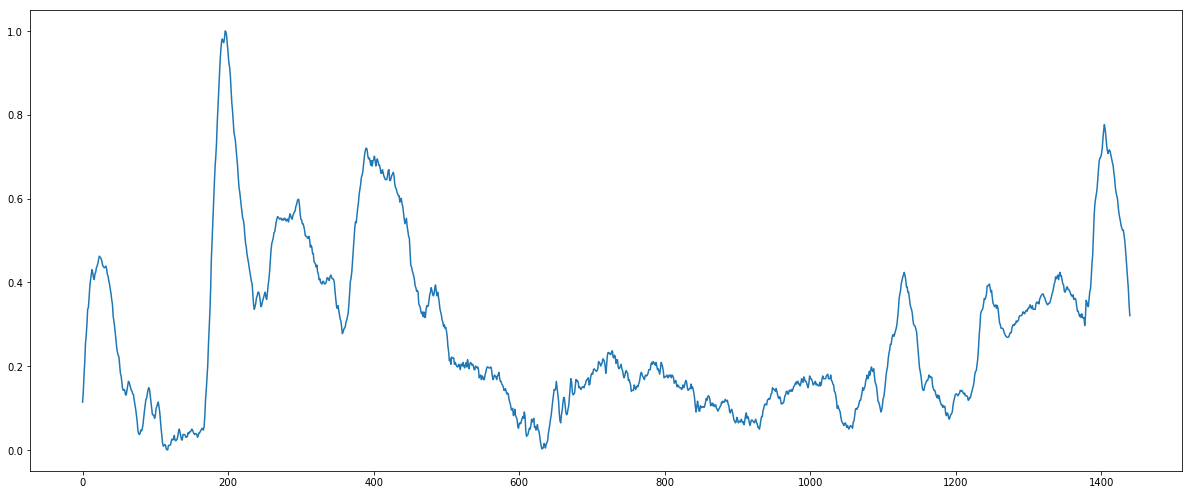

In [9]:
y = np.array([])
x = np.array([])

y = np.array(normalized01StationIndicatorVariation[singleStation])
x = np.arange(0, len(normalized01StationIndicatorVariation[singleStation]), timeBetweenValues)
fig= plt.figure(figsize=(20,8))
axes= fig.add_axes([0.8,0.8,0.8,0.8])
axes.plot(x,y)
plt.show()

In [10]:
def RemoveInfNan(latValues, indicatorValues):
    indexDeleteY = np.array([])
    for i in range(0, indicatorValues.shape[0]):
        if math.isinf(indicatorValues[i]) or math.isnan(indicatorValues[i]):
            indexDeleteY = np.append(indexDeleteY, i)
    newY = np.delete(indicatorValues, indexDeleteY)
    newX = np.delete(latValues, indexDeleteY)
    newY=newY.reshape(newY.shape[0],1)
    newX=newX.reshape(newY.shape[0],1)
    
    return newX, newY

In [45]:
predictionGap = np.array([])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0, shuffle=True)
x=x.reshape(x.shape[0],1)
y=y.reshape(y.shape[0],1)


def RemoveDataRandomly(x,y):
    rand = np.array([])
    r=0
    for i in range(0,y.shape[0]/2):
        while r in rand:
            r = random.randint(0,y.shape[0])
        rand = np.append(rand, r)

    for i in range(0,rand.shape[0]):
        y_train[np.int16(rand[i])] = np.nan
        
        
def RemoveDataGap(start, end):
    global predictionGap
    
    for i in range(start, end, 1):
        for y in range(0, X_train.shape[0]):
            if i == X_train[y]:
                y_train[y] = np.nan
                predictionGap = np.append(predictionGap,X_train[y])
        
# RemoveDataRandomly()
dataGaps = np.array([[100,200], [850,1050], [1300,1400]])
for i in range(dataGaps.shape[0]):
    RemoveDataGap(dataGaps[i][0],dataGaps[i][1])

In [46]:
X_train = X_train.reshape(X_train.shape[0], 1)
y_train = y_train.reshape(y_train.shape[0], 1) 
X_test = X_test.reshape(X_test.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

X_train, y_train = RemoveInfNan(X_train, y_train)

/home/cristille/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/home/cristille/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  import sys


In [47]:
from sklearn.metrics import make_scorer

def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

MAPE = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [69]:
def PlotResult(prediction):
    idx = np.argsort(X_test,axis=None)
    X_test_sorted = np.array([])
    y_pred_sorted = np.array([])
    X_test_sorted = np.array(X_test)[idx]
    prediction = np.array(prediction)[idx]

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.scatter(X_train, y_train, label="Base data with gaps")
    ax1.title.set_text('Train sample')
#     ax1.plot(X_test_sorted, y_pred_sorted,":r", label="Polynomial")
    ax1.plot(X_test_sorted, prediction,"-g", label="Random forest")
    ax2.title.set_text('Test sample')
    ax2.scatter(X_test, y_test, c='blue', label="Base data")
#     ax2.plot(X_test_sorted, y_pred_sorted,":r", label="Polynomial")
    ax2.plot(X_test_sorted, prediction,"-g", label="Random forest")
    fig.set_size_inches(25,7)
    ax1.set_xlabel("time (minutes)")
    ax1.set_ylabel("Normalized Data")
    ax2.set_xlabel("time (minutes)")
    ax2.set_ylabel("Normalized Data")


    ax1.legend(loc = 'best', title = 'Prediction accuracy: {}%'.format(MSE))
    ax2.legend(loc = 'best')

    fig.savefig("DataGaps_TrainAndTestSamples")

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:   14.1s finished



Best hyper parameters found at: {'linearregression__normalize': True, 'polynomialfeatures__degree': 26, 'linearregression__fit_intercept': True}
97.67% accuracy between the prediction and the test values


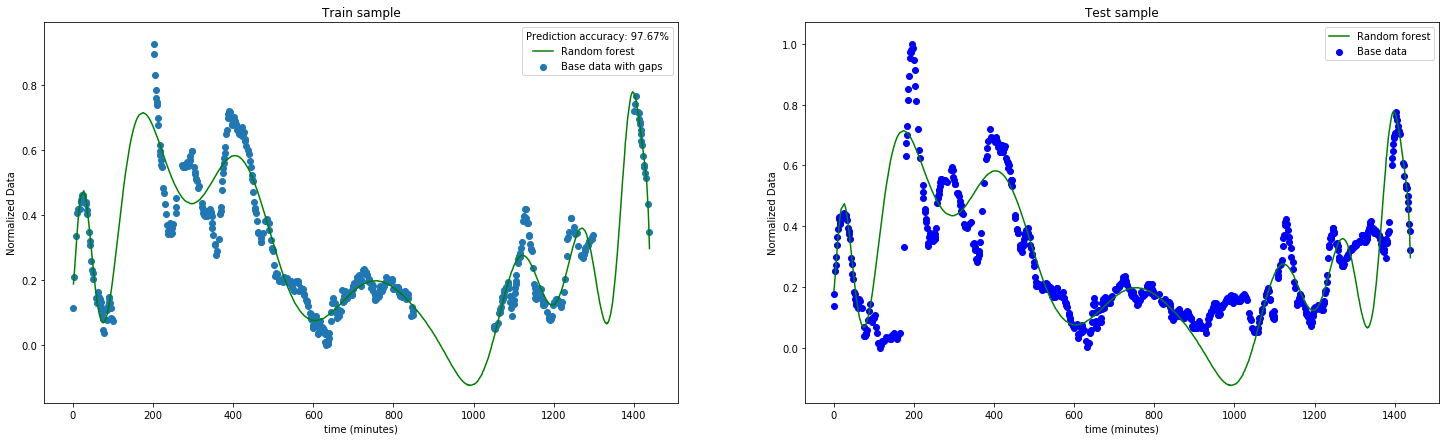

In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

params = {'polynomialfeatures__degree': np.arange(20,50,1), 'linearregression__fit_intercept': [True, False], 'linearregression__normalize': [True, False]}
poly_grid = GridSearchCV(PolynomialRegression(), params, cv=10, scoring="neg_mean_squared_error", verbose=1)
poly_grid.fit(X_train, y_train)
print("\nBest hyper parameters found at: {}".format(poly_grid.best_params_));
y_pred = poly_grid.predict(X_test)
MSEPoly=np.round((1-mean_squared_error(y_test, y_pred)),4)*100
print("{}% accuracy between the prediction and the test values".format(MSEPoly))

PlotResult(y_pred)

98.67% accuracy between the prediction and the test values


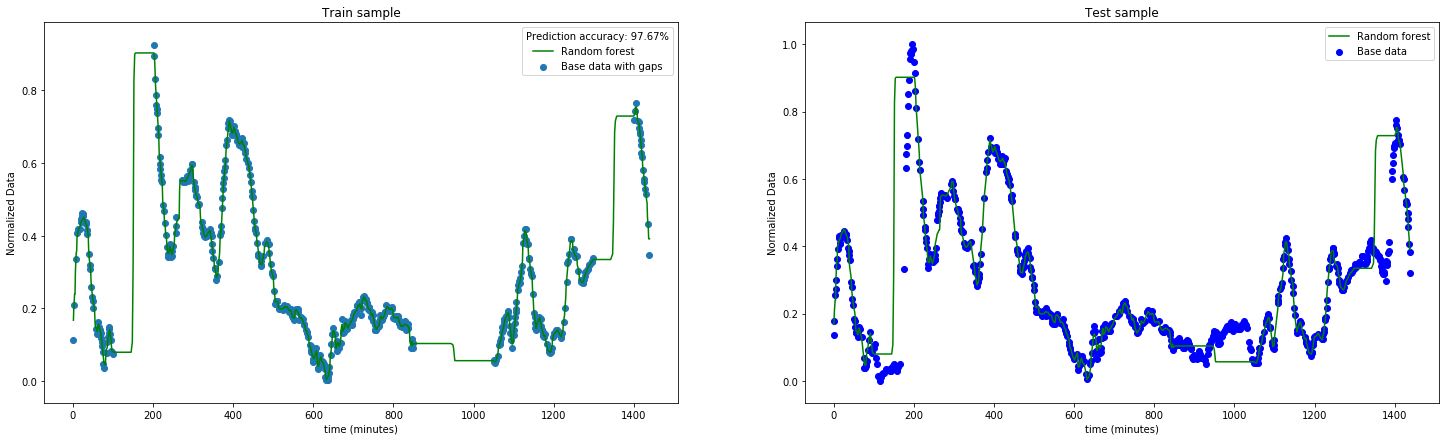

In [81]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(X_train, y_train.reshape(y_train.shape[0]))
y_predRF = rf_random.predict(X_test)

MSERF=np.round((1-mean_squared_error(y_test, y_predRF)),4)*100
print("{}% accuracy between the prediction and the test values".format(MSERF))


PlotResult(y_predRF)

95.97% accuracy between the prediction and the test values


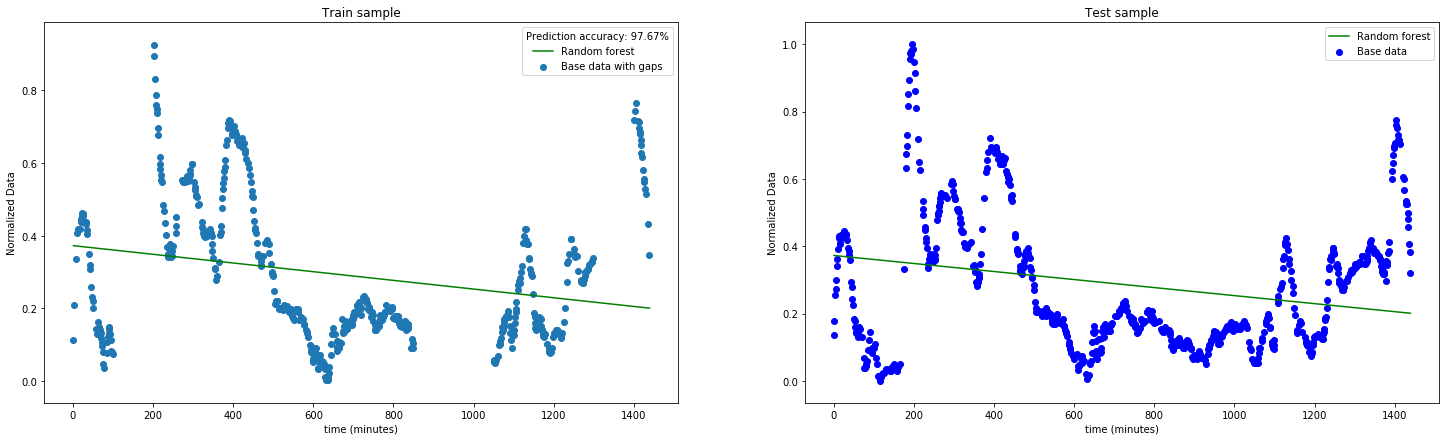

In [80]:
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression

regr = ElasticNet(random_state=2)
regr.fit(X_train, y_train)
newPred = regr.predict(X_test)

MSEnewPred=np.round((1-mean_squared_error(y_test, newPred)),4)*100
print("{}% accuracy between the prediction and the test values".format(MSEnewPred))


PlotResult(newPred)